In [21]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

import matplotlib.pyplot as plt

In [22]:
#read in the transcripts
gene_names = []
transcripts = []
name_to_transcript = {}
with open("../../Mus_musculus.GRCm38.cdna.all.fa") as f_transcript:
    cur_transcript = ""
    for line in f_transcript:
        if(line[0] == ">"):
            gene_name = line[1:]
            gene_name_arr = gene_name.split()
            gene_name = gene_name_arr[0]
            gene_names.append(gene_name)
            if(cur_transcript != ""):
                #name_to_transcript[gene_name] = transcript
                transcripts.append(cur_transcript)
                cur_transcript = ""
        else:
            cur_transcript = cur_transcript + line[:-1]
transcripts.append(cur_transcript)
for i in range(len(gene_names)):
    name_to_transcript[gene_names[i]] = transcripts[i]
for i in name_to_transcript:
    print(i)
    print(name_to_transcript[i])
    break
print(name_to_transcript['ENSMUST00000196221.1'])

ENSMUST00000153691.1
ATGAATTCCAAATCACGGAGCACAATAACTTCCGGACCTTCTTCCAAGCGCTCATGCTTCTCTTCCGGAGCGCCACAGGAGAAGCGTGGCACAACATCATGCTCTCCTGCCTCAGCGGGAAGCCGTGCGATAAGAACTCTGGGATCCTCACGGCAGACTGCGGCAACGAGTTCGCGTACTTCTACTTTGTCTCGTTCATCTTCCTGTGCTCGTTTCTGATGCTGAATCTCTTTGTCGCTGTCATCATGGACAACTTCGAGTACCTCACCCGAGATTCTTCCATCCTGGGCCCCCATCACTTGGATGAATACGTGCGTGTCTGGGCAGAGTATGACCCTGCTGCCTGGGGTCGCATGCCTTACCCGGACATGTATCAGATGCTGAGACACATGTCCCCGCCCCTGGGTCTGGGGAAGAAGTGCCCGGCCAGAGTGGCTTACAAGAGACTCCTGCGGATGGACCTGCCGGTAGCAGATGACAACACAGTTCACTTCAACTCCACCCTGATGGCTCTGATCCGAACCGCCCTTGATATCAAAATTGCCAAGG
ATGGCATAT


In [23]:
def get_gene_info(info):
    if(info == ""):
        return ""
    info_arr = info.split()
    gene_info = info_arr[0]
    if(gene_info[0] == ">"):
        return gene_info[1:]
    else:
        first_slash = gene_info.find('/')
    return gene_info[first_slash + 1:]	

In [24]:
def get_read(f_reads, seek):
    #get info, location, and read
    gene_info = ""
    info = ""
    init_loc = 0
    end_loc = 0
    read = ""
    if(seek == -1):
        seek = f_reads.seek(0,1)
    else:
        seek = f_reads.seek(seek,0)
    info_line = f_reads.readline()
    if(info_line == ""):
        return ""
    #break this into the mates location and everythin
    info_arr = info_line.split("mate")
    #print(info_arr[1])
    first_colon = info_arr[1].find(':')
    location = info_arr[1][first_colon + 1:-1]
    location_arr = location.split('-')
    init_loc = int(location_arr[0])
    end_loc = int(location_arr[1])
    
    f_reads.seek(0,1)
    read = f_reads.readline()

    gene_info = get_gene_info(info_arr[0][1:])

    return (gene_info, init_loc, end_loc, read, seek)

In [25]:
def get_alignment_score(read, transcript_segment):
    alignments = pairwise2.align.localxx(read, transcript_segment)
    scores = []
    for a in alignments:
        al1, al2, score, begin, end = a
        scores = scores + [score]
        #print(format_alignment(*a))
        break
    score = max(scores)
    #print(score)
    return score

In [26]:
def print_transcript_dist(transcript_dist, gene_name):
    plt.gca().clear()
    axes = plt.gca()
    axes.set_ylim([0, max(transcript_dist) + 1])
    plt.plot(transcript_dist)
    plt.ylabel("read coverage")
    plt.xlabel("transcript location")
    plt.title(gene_name)
    plt.savefig("simulated_dists_dropseq_bias/" + gene_name + ".png")
    return

In [36]:
def get_info(line):
    line_arr = line.split()
    transcript_name = line_arr[0].split('/')[1]
    #print(line_arr)
    i = 0
    while(True):
        if("mate" in line_arr[i]):
            break
        i = i + 1
    loc = line_arr[i]
    # print (loc)

    loc_arr = loc.split('mate')[1][2:-1].split('-')
    # print (loc_arr)
    if(len(loc_arr) == 1):
        return
    init_loc = loc_arr[0]
    end_loc = loc_arr[1]
    return (transcript_name, int(init_loc), int(end_loc))

In [43]:
def alignment_and_distribution(filename, name_to_transcript, f_scores):
    cur_transcript_name = ""
    count = 0
    read = ""
    transcript_dist = []
    num_reads = 0

    with open(filename) as f_simulated_reads:
        for line in f_simulated_reads:
            if(line[0] == '>'):
                #add the last transcript to the scores and the distribution plot
                if(get_info(line) != None):
                    (transcript_name, init_loc, end_loc) = get_info(line)
                else:
                    continue
                if(cur_transcript_name != transcript_name):
                    f_scores.write(transcript_name)
                    transcript = name_to_transcript[transcript_name]
                    if(len(transcript_dist) > 0 and num_reads > 100 and max(transcript_dist) > 17):
                        filename_arr = filename.split('/')
                        print_transcript_dist(transcript_dist, filename_arr[-1] + '_' + cur_transcript_name)
                    num_reads = 0
                    transcript_dist = []
                    cur_transcript_name = transcript_name
                    for i in range(len(transcript)):
                        transcript_dist.append(0)
            else:
                read = line[:-1]
                num_reads = num_reads + 1
                transcript_read = transcript[init_loc - 1: end_loc]
       
                alignments = pairwise2.align.localxx(read, transcript_read)
                max_a = alignments[0]
                max_score = 0
                for a in alignments:
                    al1, al2, score, begin, end = a
                    if(score > max_score):
                        max_score = score
                        max_a = a
                al1, al2, score, begin, end = max_a
                f_scores.write(str(score))
            
                transcript_dist_fragment = transcript_dist[init_loc - 1: end_loc]
                transcript_dist_fragment = [x+1 for x in transcript_dist_fragment]
                transcript_dist = transcript_dist[:init_loc - 1] + transcript_dist_fragment + transcript_dist[end_loc:]


    if(len(transcript_dist) > 0 and max(transcript_dist) > 17 and num_reads > 100):
        filename_arr = filename.split('/')
        print_transcript_dist(transcript_dist, filename_arr[-1] + '_' + transcript_name)
        

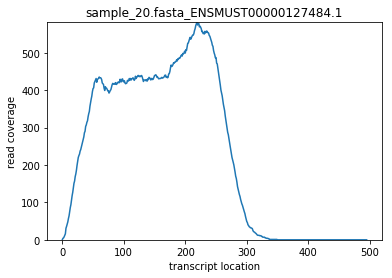

In [44]:
import os
pathname = 'simulated_dropseq_bias'
files = os.listdir(pathname)
f_scores = open("simulated_scores", "w+")
for file in files:
    alignment_and_distribution(pathname + "/" + file, name_to_transcript, f_scores)

In [3]:
transcript = name_to_transcript["ENSMUST00000000109.10"]
print(len(transcript))

5646
